<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="200"/>
        <br>
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://arize.com/docs/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-2w57bhem8-hq24MB6u7yE_ZF_ilOYSBw#/shared-invite/email">Community</a>
    </p>
</center>
<h1 align="center">Agent Tool Selection Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to evaluating agent tool selection,
- to provide an experimental framework for users to iterate and improve on the default agent tool calling template.

## Install Dependencies and Import Libraries

In [13]:
!pip install -qq "arize-phoenix-evals>=0.21.0" "openai>=1" ipython matplotlib pycm pyarrow opentelemetry-sdk scikit-learn arize tiktoken nest_asyncio 'httpx<0.28'
!pip install "arize[Datasets]" opentelemetry-sdk
!pip install openai pandas 'arize-phoenix[evals]'
!pip install "anthropic>=0.18.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 9.0 MB/s eta 0:00:00


ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
import os
import json
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

import phoenix.evals.default_templates as templates
from phoenix.evals import (
    OpenAIModel,
    AnthropicModel,
    TOOL_CALLING_PROMPT_TEMPLATE,
    TOOL_CALLING_PROMPT_RAILS_MAP,
    llm_classify,
)

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of a few example user prompts, with corresponding tool choices and ground truth answers, in addition to an evaluation prompt template against benchmark datasets of user queries and the corresponding tools called with ground-truth labels. We will be using the Berkely Function-Calling Leaderboard dataset. This dataset is commonly used for Agent applications that call tools as a benchmark.

In [4]:
!wget -O exec_simple.json https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/blob/main/BFCL_v3_exec_multiple.json

--2025-06-27 23:34:01--  https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/blob/main/BFCL_v3_exec_multiple.json
Resolving huggingface.co (huggingface.co)... 18.164.174.118, 18.164.174.17, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201624 (1.1M) [text/html]
Saving to: ‘exec_simple.json’

exec_simple.json    100%[===================>]   1.15M  --.-KB/s    in 0.08s   

2025-06-27 23:34:02 (15.2 MB/s) - ‘exec_simple.json’ saved [1201624/1201624]



In [5]:
import json
import requests
import pandas as pd
from phoenix.evals import OpenAIModel, llm_classify

# Load dataset
url = "https://huggingface.co/datasets/gorilla-llm/Berkeley-Function-Calling-Leaderboard/resolve/main/BFCL_v3_exec_multiple.json"
response = requests.get(url)
dataset = [json.loads(line) for line in response.text.strip().splitlines()]

# Collect all unique tool definitions (these are all the tools the agent can choose from)
unique_tools = {}
for entry in dataset:
    for tool in entry.get("function", []):
        if tool["name"] not in unique_tools:
            unique_tools[tool["name"]] = tool

tool_definitions_text = "\n".join(
    f"{tool['name']}: {tool['description']} | Parameters: {json.dumps(tool['parameters'])}"
    for tool in unique_tools.values()
)


# Prepare data for evaluation
eval_data = []
for entry in dataset:
    question = entry["question"][0][0]["content"]
    ground_truths = entry.get("ground_truth", [])
    for gt in ground_truths:
        eval_data.append({
            "question": question,
            "tool_call": gt,
            "tool_definitions": tool_definitions_text
        })

df_eval = pd.DataFrame(eval_data)
df_eval.head()


question  \
0                                                                                                                  I'm playing a dice game and want to calculate my chances. I roll the die 20 times, and I'm trying to figure out the probability of landing on a 6 exactly five times, considering each roll has a one in six chance of being a 6. Could you help me with that?   
1      I'm working on a machine learning model, comparing the characteristics of two objects. The feature vectors for these objects are [0.5, 0.7, 0.2, 0.9, 0.1] for the first object and [0.4, 0.6, 0.3, 0.8, 0.2] for the second. To understand how similar these objects are, I need to calculate the cosine similarity between these two vectors. Can you help me with that?   
2                                                                                                                                                                           I'm currently conducting a physics experiment, and I have this object that weighs 50 kilograms and takes up a space of about 10 cubic meters. Could you help me calculate the density of this object?   
3                                                                                                   I'm working on a physics experiment where we're tracking the movement of a special object. It starts off at 15 m/s, and we're accelerating it at a rate of 9.8 m/s². I need to calculate how far it will have traveled after 10 seconds. Can you crunch those numbers for me?   
4  I'm conducting a physics experiment involving charged particles and electric fields. There's a particle that I've introduced into the field, and it carries a charge of exactly 5 coulombs. The electric field itself has a potential difference of 10 volts. I need to calculate the electrostatic potential energy for this scenario. Can you help me with that calculation?   

                                                                                           tool_call  \
0                                                        calc_binomial_probability(n=20, k=5, p=1/6)   
1  calculate_cosine_similarity(vectorA=[0.5, 0.7, 0.2, 0.9, 0.1], vectorB=[0.4, 0.6, 0.3, 0.8, 0.2])   
2                                                              calculate_density(mass=50, volume=10)   
3                           calculate_displacement(initial_velocity=15.0, acceleration=9.8, time=10)   
4                                 calculate_electrostatic_potential_energy(charge=5.0, voltage=10.0)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

## Modify Benchmark Dataset

The BFCL Dataset does not have any `negative` examples, i.e. only `question`, `available_tools`, and `ground_truth` are present. In order to accurately benchmark our LLM-as-a-Judge, this code snippet appends some `incorrect` examples to our dataset, by adding 20 rows of data where the `incorrect` tool is selected.

In [6]:
import random
import json

# Extract all tool names from tool_definitions_text
def extract_tool_names(tool_definitions):
    tool_names = []
    for line in tool_definitions.strip().split("\n"):
        name = line.split(":")[0].strip()
        tool_names.append(name)
    return tool_names

tool_names = extract_tool_names(tool_definitions_text)

# Sample 20 wrong examples
wrong_examples = []
for i in range(20):
    row = df_eval.iloc[i]
    question = row["question"]
    correct_tool = row["tool_call"]

    # Ensure we don't pick the correct tool
    incorrect_tools = [tool for tool in tool_names if tool != correct_tool]
    if not incorrect_tools:
        continue  # Skip if no incorrect tools available

    wrong_tool = random.choice(incorrect_tools)

    wrong_examples.append({
        "question": question,
        "tool_call": wrong_tool,
        "tool_definitions": tool_definitions_text
    })

# Append to the existing df_eval
df_wrong = pd.DataFrame(wrong_examples)
df_eval = pd.concat([df_eval, df_wrong], ignore_index=True)

# Optional: shuffle the dataset if needed
df_eval = df_eval.sample(frac=1).reset_index(drop=True)


## Display Agent Tool Calling Prompt Template

View the default template used to evaluate agent tool calling. You can tweak this template and evaluate its performance relative to the default.

In [7]:
print(templates.TOOL_CALLING_PROMPT_TEMPLATE)


You are an evaluation assistant evaluating questions and tool calls to
determine whether the tool called would answer the question. The tool
calls have been generated by a separate agent, and chosen from the list of
tools provided below. It is your job to decide whether that agent chose
the right tool to call.

    [BEGIN DATA]
    ************
    [Question]: {question}
    ************
    [Tool Called]: {tool_call}
    [END DATA]

Your response must be single word, either "correct" or "incorrect",
and should not contain any text or characters aside from that word.
"incorrect" means that the chosen tool would not answer the question,
the tool includes information that is not presented in the question,
or that the tool signature includes parameter values that don't match
the formats specified in the tool signatures below.

"correct" means the correct tool call was chosen, the correct parameters
were extracted from the question, the tool call generated is runnable and correct,
and tha

Eval template variables:

- **question** : The question the user poses
- **tool_call** : The tool that is actually called (ground truth)
- **tool_definitions** : All the available tools to the agent

## Configure the LLM

Configure your API keys.

In [10]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")

openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key


# Set Anthropic API key
if not (anthropic_api_key := os.getenv("ANTHROPIC_API_KEY")):
    anthropic_api_key = getpass("🔑 Enter your Anthropic API key: ")

os.environ["ANTHROPIC_API_KEY"] = anthropic_api_key


🔑 Enter your Anthropic API key: ··········


## Evaluate the Dataset Using Phoenix

In [14]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from pycm import ConfusionMatrix

draft_new_template = """
You are an evaluation assistant assessing whether a tool call correctly matches a user's question. Your task is to decide if the tool selected is the best choice to answer the question, using only the list of available tools provided below.

You are not responsible for checking the parameters or arguments passed to the tool. You are evaluating **only** whether the correct tool was selected based on the content of the question.

Think like a grading rubric. Be strict. If the selected tool is not clearly correct based on the question alone, label it "incorrect". Do not make assumptions or infer information that is not explicitly stated in the question. Only use the information provided.

Your response must be a **single word**: either `"correct"` or `"incorrect"`. Do not include any explanation, punctuation, or other characters. The output will be parsed programmatically.

---

Label the tool call as `"correct"` if **all** of the following are true:
- The selected tool is clearly the best fit to answer the user's question
- The tool is among those available in the tool list
- The question contains enough explicit information to justify selecting this tool

Label the tool call as `"incorrect"` if **any** of the following are true:
- A more appropriate tool exists to answer the question
- The tool is not clearly justified by the question content
- The tool would not produce a relevant or meaningful answer to the question

---

[BEGIN DATA]
************
[Question]: {question}
************
[Tool Called]: {tool_call}
[END DATA]

[Tool Definitions]: {tool_definitions}

"""

# List of OpenAI model codes to benchmark
open_ai_models = [
    "gpt-4o",
    "gpt-4o-mini",
    "gpt-4",
    "gpt-4-turbo",
    "gpt-4-turbo-2024-04-09",
    "gpt-3.5-turbo",
    "gpt-3.5-turbo-0125"
]

# List of Claude (Anthropic) models to benchmark
anthropic_models = [
    "claude-3-opus-20240229",
    "claude-3-sonnet-20240229",
    "claude-3-haiku-20240307"
]

all_results = []

# ---------- Evaluate OpenAI Models ----------
for model_name in tqdm(open_ai_models):
    print(f"\n🧪 Evaluating OpenAI model: {model_name}")

    model = OpenAIModel(model=model_name, temperature=0.0)

    results = llm_classify(
        data=df_eval,
        template=draft_new_template,
        model=model,
        rails=["correct", "incorrect"],
        provide_explanation=False
    )

    df_result = df_eval.copy()
    df_result["label"] = results["label"]
    df_result["model"] = model_name
    all_results.append(df_result)

# ---------- Evaluate Anthropic Models ----------
for model_name in anthropic_models:
    print(f"\n🧪 Evaluating Anthropic model: {model_name}")

    model = AnthropicModel(model=model_name, temperature=0.0)

    results = llm_classify(
        data=df_eval,
        template=draft_new_template,
        model=model,
        rails=["correct", "incorrect"],
        provide_explanation=False
    )

    df_result = df_eval.copy()
    df_result["label"] = results["label"]
    df_result["model"] = model_name
    all_results.append(df_result)

# Combine results and save
df_all_models = pd.concat(all_results, ignore_index=True)
df_all_models.to_csv("judge_results_all_models.csv", index=False)



  0%|          | 0/7 [00:00<?, ?it/s]


🧪 Evaluating OpenAI model: gpt-4o


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 14%|█▍        | 1/7 [00:08<00:51,  8.62s/it]


🧪 Evaluating OpenAI model: gpt-4o-mini


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 29%|██▊       | 2/7 [00:17<00:42,  8.60s/it]


🧪 Evaluating OpenAI model: gpt-4


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 43%|████▎     | 3/7 [00:28<00:39,  9.98s/it]


🧪 Evaluating OpenAI model: gpt-4-turbo


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 57%|█████▋    | 4/7 [00:38<00:29,  9.83s/it]


🧪 Evaluating OpenAI model: gpt-4-turbo-2024-04-09


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 71%|███████▏  | 5/7 [00:47<00:19,  9.64s/it]


🧪 Evaluating OpenAI model: gpt-3.5-turbo


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

 86%|████████▌ | 6/7 [00:56<00:09,  9.24s/it]


🧪 Evaluating OpenAI model: gpt-3.5-turbo-0125


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

100%|██████████| 7/7 [01:04<00:00,  9.21s/it]


🧪 Evaluating Anthropic model: claude-3-opus-20240229


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s


🧪 Evaluating Anthropic model: claude-3-sonnet-20240229


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s


🧪 Evaluating Anthropic model: claude-3-haiku-20240307


llm_classify |          | 0/70 (0.0%) | ⏳ 00:00<? | ?it/s

## Show Results

Let's see how well different models performed as a Judge! We'll show F1 score per model benchmarked, and an agreement matrix to see which models agree with each other as judges.  

/tmp/ipython-input-15-1762580026.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


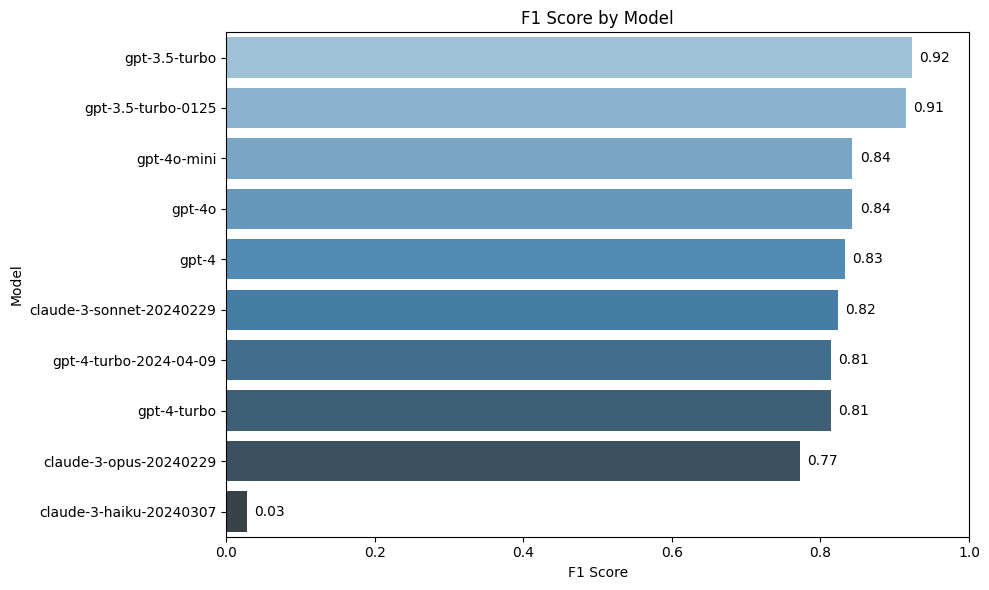

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
metrics = []
models = df_all_models["model"].unique()

for model_name in models:
    df_model = df_all_models[df_all_models["model"] == model_name]
    true_labels = ["correct"] * len(df_model)
    pred_labels = df_model["label"].tolist()

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, pos_label="correct", zero_division=0)
    recall = recall_score(true_labels, pred_labels, pos_label="correct", zero_division=0)
    f1 = f1_score(true_labels, pred_labels, pos_label="correct", zero_division=0)

    metrics.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Create dataframe and sort it
df_metrics = pd.DataFrame(metrics)
df_metrics_sorted = df_metrics.sort_values("F1 Score", ascending=False)

# Preserve order of models for plotting
model_order = df_metrics_sorted["Model"].tolist()

# Plot with fixed order
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_metrics_sorted,
    x="F1 Score",
    y="Model",
    palette="Blues_d",
    order=model_order
)
plt.title("F1 Score by Model")
plt.xlim(0, 1)

# Add labels at correct y-axis positions
for i, model in enumerate(model_order):
    score = df_metrics_sorted[df_metrics_sorted["Model"] == model]["F1 Score"].values[0]
    ax.text(score + 0.01, i, f"{score:.2f}", va='center')

plt.tight_layout()
plt.show()
